# Chapter 7 - Moving Beyond Linearity

- [Lab: 7.8.1 Polynomial Regression and Step Functions](#7.8.1-Polynomial-Regression-and-Step-Functions)
- [Lab: 7.8.2 Splines](#7.8.2-Splines)

In [57]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf
from patsy import dmatrix

from pygam import LogisticGAM
from pygam import LinearGAM

%matplotlib inline
plt.style.use('seaborn-white')

#%config InlineBackend.figure_format = 'svg'
%config InlineBackend.figure_format = 'png'

### Load dataset
Using write.csv in R, I exported the dataset from package 'ISLR' to a csv file.

In [58]:
df = pd.read_csv('../data/Wage.csv', index_col=0)
df.head(3)

,year,age,sex,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
231655,2006,18,1. Male,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
86582,2004,24,1. Male,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
161300,2003,45,1. Male,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177


In [59]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 231655 to 453557
Data columns (total 12 columns):
year          3000 non-null int64
age           3000 non-null int64
sex           3000 non-null object
maritl        3000 non-null object
race          3000 non-null object
education     3000 non-null object
region        3000 non-null object
jobclass      3000 non-null object
health        3000 non-null object
health_ins    3000 non-null object
logwage       3000 non-null float64
wage          3000 non-null float64
dtypes: float64(2), int64(2), object(8)
memory usage: 304.7+ KB


## Lab

### 7.8.1 Polynomial Regression and Step Functions

Create polynomials for 'age'. These correspond to those in R, when using raw=TRUE in poly() function.

In [60]:
X1 = PolynomialFeatures(1).fit_transform(df.age.values.reshape(-1,1))
X2 = PolynomialFeatures(2).fit_transform(df.age.values.reshape(-1,1))
X3 = PolynomialFeatures(3).fit_transform(df.age.values.reshape(-1,1))
X4 = PolynomialFeatures(4).fit_transform(df.age.values.reshape(-1,1))
X5 = PolynomialFeatures(5).fit_transform(df.age.values.reshape(-1,1))

y = (df.wage > 250).map({False:0, True:1}).values
print('X4:\n', X4[:5])
print('y:\n', y[:5])

X4:
 [[1.000000e+00 1.800000e+01 3.240000e+02 5.832000e+03 1.049760e+05]
 [1.000000e+00 2.400000e+01 5.760000e+02 1.382400e+04 3.317760e+05]
 [1.000000e+00 4.500000e+01 2.025000e+03 9.112500e+04 4.100625e+06]
 [1.000000e+00 4.300000e+01 1.849000e+03 7.950700e+04 3.418801e+06]
 [1.000000e+00 5.000000e+01 2.500000e+03 1.250000e+05 6.250000e+06]]
y:
 [0 0 0 0 0]


#### Linear regression model. (Degree 4)

In [61]:
fit2 = sm.GLS(df.wage, X4).fit()
fit2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-184.1542,60.040,-3.067,0.002,-301.879,-66.430
x1,21.2455,5.887,3.609,0.000,9.703,32.788
x2,-0.5639,0.206,-2.736,0.006,-0.968,-0.160
x3,0.0068,0.003,2.221,0.026,0.001,0.013
x4,-3.204e-05,1.64e-05,-1.952,0.051,-6.42e-05,1.45e-07


Selecting a suitable degree for the polynomial of age.

In [62]:
X = X4

Scikit-learn implements a regularized logistic regression model particularly suitable for high dimensional data. Since we just have one feature (age) we use the GLM model from statsmodels.

In [63]:
clf = sm.GLM(y, X, family=sm.families.Binomial(sm.families.links.logit))
res = clf.fit()

Create array of test data. Transform to polynomial degree 4 and run prediction.

In [64]:
age_grid = np.arange(df.age.min(), df.age.max()).reshape(-1,1)

In [65]:
X_test = PolynomialFeatures(4).fit_transform(age_grid)
pred = res.predict(X_test)

### Figure 7.1

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


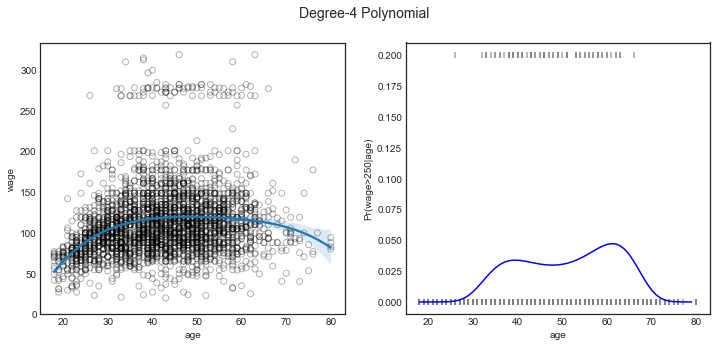

In [66]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Degree-4 Polynomial', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
sns.regplot(df.age, df.wage, order = 4, truncate=True, scatter=False, ax=ax1)
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(age_grid, pred, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

#### Step function

In [67]:
df_cut, bins = pd.cut(df.age, 4, retbins=True, right=True)
df_cut.value_counts(sort=False)

(17.938, 33.5]     750
(33.5, 49.0]      1399
(49.0, 64.5]       779
(64.5, 80.0]        72
Name: age, dtype: int64

In [68]:
df_steps = pd.concat([df.age, df_cut, df.wage], keys=['age','age_cuts','wage'], axis=1)
df_steps.head(5)

,age,age_cuts,wage
231655,18,"(17.938, 33.5]",75.043154
86582,24,"(17.938, 33.5]",70.476020
161300,45,"(33.5, 49.0]",130.982177
155159,43,"(33.5, 49.0]",154.685293
11443,50,"(49.0, 64.5]",75.043154


In [69]:
# Create dummy variables for the age groups
df_steps_dummies = pd.get_dummies(df_steps['age_cuts'])

# Statsmodels requires explicit adding of a constant (intercept)
df_steps_dummies = sm.add_constant(df_steps_dummies)

df_steps_dummies.head(5)

,const,"(17.938, 33.5]","(33.5, 49.0]","(49.0, 64.5]","(64.5, 80.0]"
231655,1.0,1,0,0,0
86582,1.0,1,0,0,0
161300,1.0,0,1,0,0
155159,1.0,0,1,0,0
11443,1.0,0,0,1,0


In [70]:
# Using statsmodels because it has a more complete output for coefficients
fit3 = sm.GLM(df_steps.wage, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1)).fit()
fit3.summary().tables[1]

,coef,std err,z,P>|z|,[0.025,0.975]
const,94.1584,1.476,63.790,0.000,91.265,97.051
"(33.5, 49.0]",24.0535,1.829,13.148,0.000,20.468,27.639
"(49.0, 64.5]",23.6646,2.068,11.443,0.000,19.611,27.718
"(64.5, 80.0]",7.6406,4.987,1.532,0.126,-2.135,17.416


In [71]:
# Put the test data in the same bins as the training data.
bin_mapping = np.digitize(age_grid.ravel(), bins)
bin_mapping

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], dtype=int64)

In [72]:
# Get dummies, drop first dummy category, add constant
X_test2 = sm.add_constant(pd.get_dummies(bin_mapping).drop(1, axis=1))
X_test2.head()

,const,2,3,4
0,1.0,0,0,0
1,1.0,0,0,0
2,1.0,0,0,0
3,1.0,0,0,0
4,1.0,0,0,0


#### Linear Regression

In [73]:
pred2 = fit3.predict(X_test2)

#### Logistic Regression

In [74]:
clf2 = sm.GLM(y, df_steps_dummies.drop(df_steps_dummies.columns[1], axis=1),
              family=sm.families.Binomial(sm.families.links.logit))
res2 = clf2.fit()
pred3 = res2.predict(X_test2)

### Figure 7.2

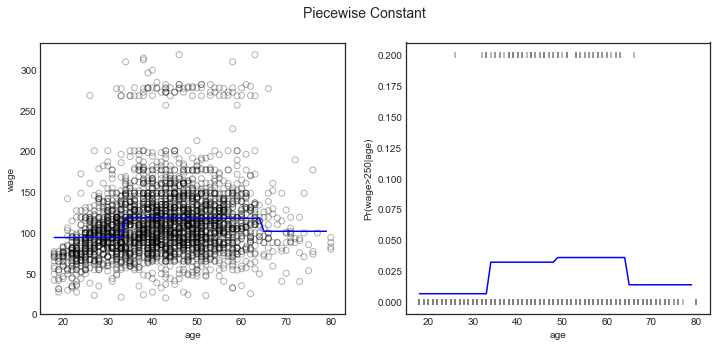

In [75]:
# creating plots
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,5))
fig.suptitle('Piecewise Constant', fontsize=14)

# Scatter plot with polynomial regression line
ax1.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
ax1.plot(age_grid, pred2, c='b')

ax1.set_xlabel('age')
ax1.set_ylabel('wage')
ax1.set_ylim(ymin=0)

# Logistic regression showing Pr(wage>250) for the age range.
ax2.plot(np.arange(df.age.min(), df.age.max()).reshape(-1,1), pred3, color='b')

# Rug plot showing the distribution of wage>250 in the training data.
# 'True' on the top, 'False' on the bottom.
ax2.scatter(df.age, y/5, s=30, c='grey', marker='|', alpha=0.7)

ax2.set_ylim(-0.01,0.21)
ax2.set_xlabel('age')
ax2.set_ylabel('Pr(wage>250|age)');

### 7.8.2 Splines

Using patsy to create non-linear transformations of the input data. See http://patsy.readthedocs.org/en/latest/ <BR>


#### Cubic splines

In [76]:
# Specifying 3 knots
transformed_x = dmatrix("bs(df.age, knots=(25,40,60), degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit4 = sm.GLM(df.wage, transformed_x).fit()
pred4 = fit4.predict(dmatrix("bs(age_grid, knots=(25,40,60), degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
fit4.params

Intercept                                                               60.493714
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[0]     3.980500
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[1]    44.630980
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[2]    62.838788
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[3]    55.990830
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[4]    50.688098
bs(df.age, knots=(25, 40, 60), degree=3, include_intercept=False)[5]    16.606142
dtype: float64

In [77]:
# Specifying 6 degrees of freedom 
transformed_x2 = dmatrix("bs(df.age, df=6, degree=3, include_intercept=False)",
                        {"df.age": df.age}, return_type='dataframe')
fit5 = sm.GLM(df.wage, transformed_x2).fit()
pred5 = fit5.predict(dmatrix("bs(age_grid, df=6, degree=3, include_intercept=False)",
                             {"age_grid": age_grid}, return_type='dataframe'))
fit5.params

Intercept                                                 56.313841
bs(df.age, df=6, degree=3, include_intercept=False)[0]    27.824002
bs(df.age, df=6, degree=3, include_intercept=False)[1]    54.062546
bs(df.age, df=6, degree=3, include_intercept=False)[2]    65.828391
bs(df.age, df=6, degree=3, include_intercept=False)[3]    55.812734
bs(df.age, df=6, degree=3, include_intercept=False)[4]    72.131473
bs(df.age, df=6, degree=3, include_intercept=False)[5]    14.750876
dtype: float64

#### Natural splines

In [78]:
# Specifying 4 degrees of freedom
transformed_x3 = dmatrix("cr(df.age, df=4)", {"df.age": df.age}, return_type='dataframe')
fit6 = sm.GLM(df.wage, transformed_x3).fit()
pred6 = fit6.predict(dmatrix("cr(age_grid, df=4)", {"age_grid": age_grid}, return_type='dataframe'))
fit6.params

Intercept              79.642095
cr(df.age, df=4)[0]   -14.667784
cr(df.age, df=4)[1]    36.811142
cr(df.age, df=4)[2]    35.934874
cr(df.age, df=4)[3]    21.563863
dtype: float64

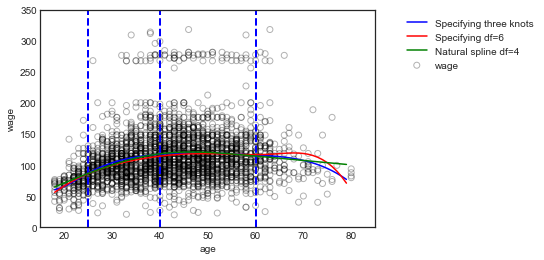

In [79]:

plt.scatter(df.age, df.wage, facecolor='None', edgecolor='k', alpha=0.3)
plt.plot(age_grid, pred4, color='b', label='Specifying three knots')
plt.plot(age_grid, pred5, color='r', label='Specifying df=6')
plt.plot(age_grid, pred6, color='g', label='Natural spline df=4')
[plt.vlines(i , 0, 350, linestyles='dashed', lw=2, colors='b') for i in [25,40,60]]
plt.legend(bbox_to_anchor=(1.5, 1.0))
plt.xlim(15,85)
plt.ylim(0,350)
plt.xlabel('age')
plt.ylabel('wage');

In [84]:
from pygam.datasets import wage

X, y = wage()

Let’s fit a spline term to the first 2 features, and a factor term to the 3rd feature.

In [85]:
from pygam import LinearGAM, s, f

gam = LinearGAM(s(0) + s(1) + f(2)).fit(X, y)


gam.summary()



LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                     25.1911
Link Function:                     IdentityLink Log Likelihood:                                -24118.6847
Number of Samples:                         3000 AIC:                                            48289.7516
                                                AICc:                                           48290.2307
                                                GCV:                                             1255.6902
                                                Scale:                                           1236.7251
                                                Pseudo R-Squared:                                   0.2955
Feature Function                  Lam

C:\Users\loecherm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:6: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  


##### Automatically tune the model

By default, spline terms, s() have a penalty on their 2nd derivative, which encourages the functions to be smoother, while factor terms, f() and linear terms l(), have a l2, ie ridge penalty, which encourages them to take on smaller values.

lam, short for λ , controls the strength of the regularization penalty on each term. Terms can have multiple penalties, and therefore multiple lam.


In [86]:
print(gam.lam)

[[0.6], [0.6], [0.6]]


##### Grid search with pyGAM

The gridsearch()function creates a grid to search over smoothing parameters. 

Our model has 3 lam parameters, currently just one per term.
Let’s perform a grid-search over multiple lam values to see if we can improve our model.
We will seek the model with the lowest generalized cross-validation (GCV) score.

Our search space is 3-dimensional, so we have to be conservative with the number of points we consider per dimension.

Let’s try 5 values for each smoothing parameter, resulting in a total of 5*5*5 = 125 points in our grid.

In [87]:
lam = np.logspace(-3, 5, 5)
lams = [lam] * 3

gam.gridsearch(X, y, lam=lams)
gam.summary()

100% (125 of 125) |######################| Elapsed Time: 0:00:16 Time:  0:00:16


LinearGAM                                                                                                 
=============================================== ==========================================================
Distribution:                        NormalDist Effective DoF:                                      9.6668
Link Function:                     IdentityLink Log Likelihood:                                 -24119.413
Number of Samples:                         3000 AIC:                                            48260.1595
                                                AICc:                                           48260.2428
                                                GCV:                                             1244.2375
                                                Scale:                                           1237.0229
                                                Pseudo R-Squared:                                   0.2916
Feature Function                  Lam

C:\Users\loecherm\AppData\Roaming\Python\Python36\site-packages\ipykernel_launcher.py:5: UserWarning: KNOWN BUG: p-values computed in this summary are likely much smaller than they should be. 
 
Please do not make inferences based on these values! 

Collaborate on a solution, and stay up to date at: 
github.com/dswah/pyGAM/issues/163 

  """


#### Partial Dependence Functions

One of the most attractive properties of GAMs is that we can decompose and inspect the contribution of each feature to the overall prediction.

This is done via partial dependence functions.

Let’s plot the partial dependence for each term in our model, along with a 95% confidence interval for the estimated function.

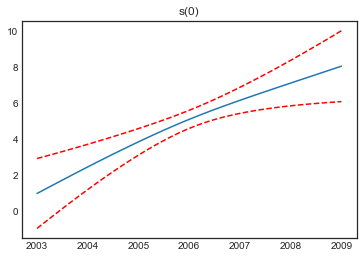

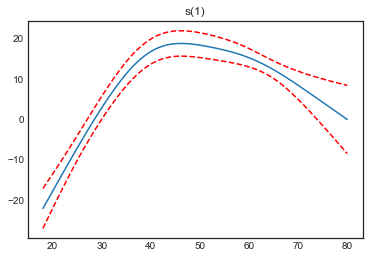

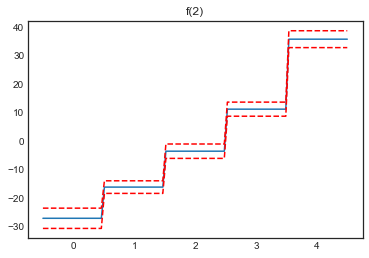

In [88]:
for i, term in enumerate(gam.terms):
    if term.isintercept:
        continue

    XX = gam.generate_X_grid(term=i)
    pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

    plt.figure()
    plt.plot(XX[:, term.feature], pdep)
    plt.plot(XX[:, term.feature], confi, c='r', ls='--')
    plt.title(repr(term))
    plt.show()